# Gradient Visualization for Radial 1D Stellar Wind Simulation

## Imports

In [1]:
# numerics
import jax
import jax.numpy as jnp
# # for now using CPU as of outdated NVIDIA Driver
# jax.config.update('jax_platform_name', 'cpu')
# # jax.config.update('jax_disable_jit', True)
# # 64-bit precision
# jax.config.update("jax_enable_x64", True)

# debug nans
# jax.config.update("jax_debug_nans", True)

# timing
from timeit import default_timer as timer

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# fluids
from jf1uids import OPEN_BOUNDARY, REFLECTIVE_BOUNDARY
from jf1uids import SPHERICAL
from jf1uids import WindParams
from jf1uids import SimulationConfig
from jf1uids import get_helper_data
from jf1uids import SimulationParams
from jf1uids import time_integration
from jf1uids import construct_primitive_state

from jf1uids import get_registered_variables
from jf1uids.option_classes import WindConfig


# units
from jf1uids import CodeUnits
from astropy import units as u
import astropy.constants as c
from astropy.constants import m_p

# wind-specific
from jf1uids._physics_modules._stellar_wind.weaver import Weaver

## Initiating the stellar wind simulation

In [2]:
print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
geometry = SPHERICAL
box_size = 1.0
num_cells = 401

left_boundary = REFLECTIVE_BOUNDARY
right_boundary = OPEN_BOUNDARY

# activate stellar wind
stellar_wind = True

fixed_timestep = True
num_timesteps = 10000

# setup simulation config
config = SimulationConfig(
    geometry = geometry,
    box_size = box_size, 
    num_cells = num_cells,
    left_boundary = left_boundary, 
    right_boundary = right_boundary,
    wind_config = WindConfig(
        stellar_wind = stellar_wind,
        num_injection_cells = 10,
        trace_wind_density = True,
    ),
    # fixed_timestep = fixed_timestep,
    # num_timesteps = num_timesteps,
    # first_order_fallback = True,
)

helper_data = get_helper_data(config)

registered_variables = get_registered_variables(config)

👷 Setting up simulation...


2025-01-30 10:29:55.125049: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:0: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [3]:
config_high_res = SimulationConfig(
    geometry = geometry,
    box_size = box_size, 
    num_cells = 2001,
    left_boundary = left_boundary, 
    right_boundary = right_boundary, 
    wind_config = WindConfig(
        stellar_wind = stellar_wind,
        num_injection_cells = 10,
    ),
    # fixed_timestep = fixed_timestep,
    # num_timesteps = num_timesteps,
    # first_order_fallback = True,
)

helper_data_high_res = get_helper_data(config_high_res)

## Setting the simulation parameters and initial state

In [4]:
# code units
code_length = 3 * u.parsec
code_mass = 1e-3 * u.M_sun
code_velocity = 1 * u.km / u.s
code_units = CodeUnits(code_length, code_mass, code_velocity)

# time domain
C_CFL = 0.8
t_final = 2.5 * 1e4 * u.yr
t_end = t_final.to(code_units.code_time).value
dt_max = 0.1 * t_end

# wind parameters
M_star = 40 * u.M_sun
wind_final_velocity = 2000 * u.km / u.s
wind_mass_loss_rate = 2.965e-3 / (1e6 * u.yr) * M_star

wind_params = WindParams(
    wind_mass_loss_rate = wind_mass_loss_rate.to(code_units.code_mass / code_units.code_time).value,
    wind_final_velocity = wind_final_velocity.to(code_units.code_velocity).value
)

params = SimulationParams(
    C_cfl = C_CFL,
    dt_max = dt_max,
    gamma = gamma,
    t_end = t_end,
    wind_params=wind_params
)

params_high_res = SimulationParams(
    C_cfl = C_CFL,
    dt_max = dt_max,
    gamma = gamma,
    t_end = t_end,
    wind_params=wind_params
)

# homogeneous initial state
rho_0 = 2 * c.m_p / u.cm**3
p_0 = 3e4 * u.K / u.cm**3 * c.k_B

rho_init = jnp.ones(num_cells) * rho_0.to(code_units.code_density).value
u_init = jnp.zeros(num_cells)
p_init = jnp.ones(num_cells) * p_0.to(code_units.code_pressure).value

# get initial state
initial_state = construct_primitive_state(rho_init, u_init, p_init, registered_variables)

# initial state high res
rho_init_high_res = jnp.ones(config_high_res.num_cells) * rho_0.to(code_units.code_density).value
u_init_high_res = jnp.zeros(config_high_res.num_cells)
p_init_high_res = jnp.ones(config_high_res.num_cells) * p_0.to(code_units.code_pressure).value

initial_state_high_res = construct_primitive_state(rho_init_high_res, u_init_high_res, p_init_high_res, registered_variables)

## Simulation and Gradient

In [5]:
final_state = time_integration(initial_state, config, params, helper_data, registered_variables)

# high res final state
final_state_high_res = time_integration(initial_state_high_res, config_high_res, params_high_res, helper_data_high_res, registered_variables)

def integrator(velocity):
    return time_integration(initial_state, config, SimulationParams(C_cfl=params.C_cfl, dt_max=params.dt_max, gamma=params.gamma, t_end=params.t_end, wind_params=WindParams(wind_mass_loss_rate=params.wind_params.wind_mass_loss_rate, wind_final_velocity=velocity)), helper_data, registered_variables)

vel_sens = jax.jacfwd(integrator)(params.wind_params.wind_final_velocity)

# calculate the finite difference derivative
dv = 0.1
# print dv in km/s
print(f"dv = {(dv * code_units.code_velocity).to(u.km/u.s)}")
vel_sens_fd = (integrator(params.wind_params.wind_final_velocity + dv) - integrator(params.wind_params.wind_final_velocity - dv)) / (2 * dv)


dv = 0.1 km / s


## Visualization

👷 generating plots
0.00852260137538079 code_length / code_velocity


/tmp/ipykernel_3095584/1688762253.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


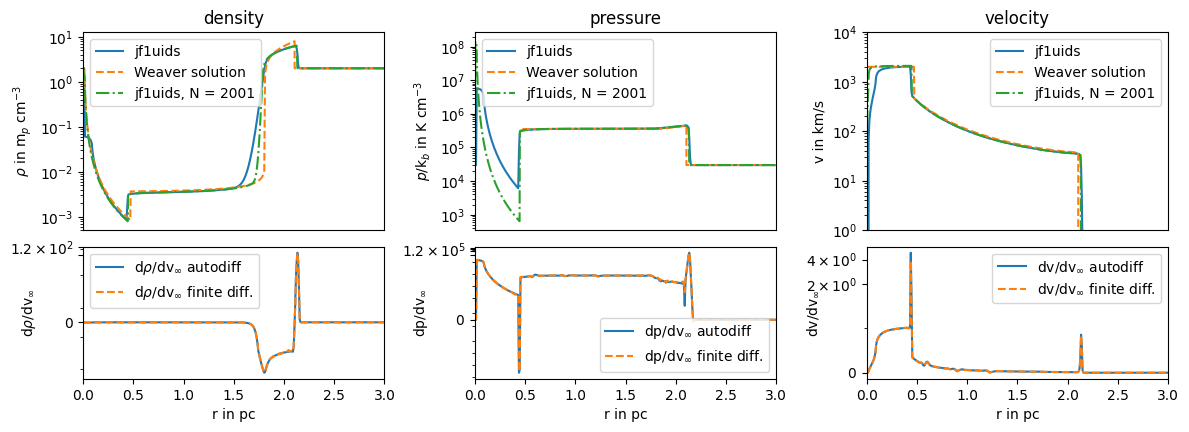

In [6]:
def plot_weaver_comparison(axs, final_state, params, helper_data, code_units, rho_0, p_0):
    print("👷 generating plots")

    rho = final_state[registered_variables.density_index]
    vel = final_state[registered_variables.velocity_index]
    p = final_state[registered_variables.pressure_index]

    rho = rho * code_units.code_density
    vel = vel * code_units.code_velocity
    p = p * code_units.code_pressure

    r_high_res = helper_data_high_res.geometric_centers * code_units.code_length

    rho_high_res = final_state_high_res[registered_variables.density_index]
    vel_high_res = final_state_high_res[registered_variables.velocity_index]
    p_high_res = final_state_high_res[registered_variables.pressure_index]

    rho_high_res = rho_high_res * code_units.code_density
    vel_high_res = vel_high_res * code_units.code_velocity
    p_high_res = p_high_res * code_units.code_pressure

    r = helper_data.geometric_centers * code_units.code_length

    # get weaver solution
    weaver = Weaver(
        params.wind_params.wind_final_velocity * code_units.code_velocity,
        params.wind_params.wind_mass_loss_rate * code_units.code_mass / code_units.code_time,
        rho_0,
        p_0
    )
    current_time = params.t_end * code_units.code_time# + 12e-4 * code_units.code_time
    print(current_time)
    
    # density
    r_density_weaver, density_weaver = weaver.get_density_profile(0.01 * u.parsec, 3.5 * u.parsec, current_time)
    r_density_weaver = r_density_weaver.to(u.parsec)
    density_weaver = (density_weaver / m_p).to(u.cm**-3)

    # velocity
    r_velocity_weaver, velocity_weaver = weaver.get_velocity_profile(0.01 * u.parsec, 3.5 * u.parsec, current_time)
    r_velocity_weaver = r_velocity_weaver.to(u.parsec)
    velocity_weaver = velocity_weaver.to(u.km / u.s)

    # pressure
    r_pressure_weaver, pressure_weaver = weaver.get_pressure_profile(0.01 * u.parsec, 3.5 * u.parsec, current_time)
    r_pressure_weaver = r_pressure_weaver.to(u.parsec)
    pressure_weaver = (pressure_weaver / c.k_B).to(u.cm**-3 * u.K)

    axs[0].set_yscale("log")
    axs[0].plot(r.to(u.parsec), (rho / m_p).to(u.cm**-3), label="jf1uids")

    axs[0].plot(r_density_weaver, density_weaver, "--", label="Weaver solution")

    axs[0].plot(r_high_res.to(u.parsec), (rho_high_res / m_p).to(u.cm**-3), "-.", label="jf1uids, N = {}".format(config_high_res.num_cells))

    axs[0].set_title("density")
    axs[0].set_ylabel(r"$\rho$ in m$_p$ cm$^{-3}$")
    axs[0].set_xlim(0, 3)

    axs[0].legend(loc="upper left")

    # turn off x ticks
    axs[0].set_xticks([])
    axs[1].set_xticks([])
    axs[2].set_xticks([])

    axs[1].set_yscale("log")
    axs[1].plot(r.to(u.parsec), (p / c.k_B).to(u.K / u.cm**3), label="jf1uids")
    axs[1].plot(r_pressure_weaver, pressure_weaver, "--", label="Weaver solution")
    axs[1].plot(r_high_res.to(u.parsec), (p_high_res / c.k_B).to(u.K / u.cm**3), "-.", label="jf1uids, N = {}".format(config_high_res.num_cells))

    axs[1].set_title("pressure")
    axs[1].set_ylabel(r"$p$/k$_b$ in K cm$^{-3}$")
    axs[1].set_xlim(0, 3)

    axs[1].legend(loc="upper left")


    axs[2].set_yscale("log")
    axs[2].plot(r.to(u.parsec), vel.to(u.km / u.s), label="jf1uids")
    axs[2].plot(r_velocity_weaver, velocity_weaver, "--", label="Weaver solution")
    axs[2].plot(r_high_res.to(u.parsec), vel_high_res.to(u.km / u.s), "-.", label="jf1uids, N = {}".format(config_high_res.num_cells))
    axs[2].set_title("velocity")
    # ylim 1 to 1e4 km/s
    axs[2].set_ylim(1, 1e4)
    axs[2].set_xlim(0, 3)
    axs[2].set_ylabel("v in km/s")
    # xlabel
    # show legend upper left
    axs[2].legend(loc="upper right")

def sensitivity_plot(axs, vel_sens, vel_sens_fd):

    rho_sens_vel = vel_sens[registered_variables.density_index]
    vel_sens_vel = vel_sens[registered_variables.velocity_index]
    p_sens_vel = vel_sens[registered_variables.pressure_index]

    rho_sens_vel_fd = vel_sens_fd[registered_variables.density_index]
    vel_sens_vel_fd = vel_sens_fd[registered_variables.velocity_index]
    p_sens_vel_fd = vel_sens_fd[registered_variables.pressure_index]

    r = helper_data.geometric_centers * code_units.code_length

    axs[0].plot(r.to(u.parsec), rho_sens_vel, label=r"d$\rho$/dv$_\infty$ autodiff")
    axs[0].plot(r.to(u.parsec), rho_sens_vel_fd, "--", label=r"d$\rho$/dv$_\infty$ finite diff.")
    axs[0].set_ylabel(r"d$\rho$/dv$_\infty$")
    axs[0].legend(loc = "upper left")
    axs[0].tick_params(axis='y')
    axs[0].set_yscale('symlog')
    axs[0].set_xlim(0, 3)
    axs[0].set_xlabel("r in pc")
    axs[0].yaxis.set_label_coords(-0.15, 0.5)

    axs[1].plot(r.to(u.parsec), p_sens_vel, label=r"dp/dv$_\infty$ autodiff")
    axs[1].plot(r.to(u.parsec), p_sens_vel_fd, "--", label=r"dp/dv$_\infty$ finite diff.")
    axs[1].set_ylabel(r"dp/dv$_\infty$")
    axs[1].legend(loc = "lower right")
    axs[1].tick_params(axis='y')
    axs[1].set_yscale('symlog')
    axs[1].set_xlim(0, 3)
    axs[1].set_xlabel("r in pc")
    axs[1].yaxis.set_label_coords(-0.15, 0.5)

    axs[2].plot(r.to(u.parsec), vel_sens_vel, label=r"dv/dv$_\infty$ autodiff")
    axs[2].plot(r.to(u.parsec), vel_sens_vel_fd, "--", label=r"dv/dv$_\infty$ finite diff.")
    axs[2].set_ylabel(r"dv/dv$_\infty$")
    axs[2].legend(loc = "upper right")
    axs[2].tick_params(axis='y')
    axs[2].set_yscale('symlog')
    axs[2].set_xlim(0, 3)
    axs[2].set_xlabel("r in pc")
    axs[2].yaxis.set_label_coords(-0.15, 0.5)

    axs[0].yaxis.set_major_locator(plt.MaxNLocator(3))
    axs[1].yaxis.set_major_locator(plt.MaxNLocator(6))
    axs[2].yaxis.set_major_locator(plt.MaxNLocator(3))


fig = plt.figure(figsize=(14, 4.5))

gs = GridSpec(2, 3, height_ratios=[3, 2], figure=fig, hspace=0.1, wspace=0.3)

axs_upper = [fig.add_subplot(gs[0, i]) for i in range(3)]
axs_lower = [fig.add_subplot(gs[1, i]) for i in range(3)]

plot_weaver_comparison(axs_upper, final_state, params, helper_data, code_units, rho_0, p_0)
sensitivity_plot(axs_lower, vel_sens, vel_sens_fd)

plt.tight_layout()

# TODO: add finite difference here

plt.savefig("figures/gradients_through_stellar_wind.pdf", bbox_inches="tight")

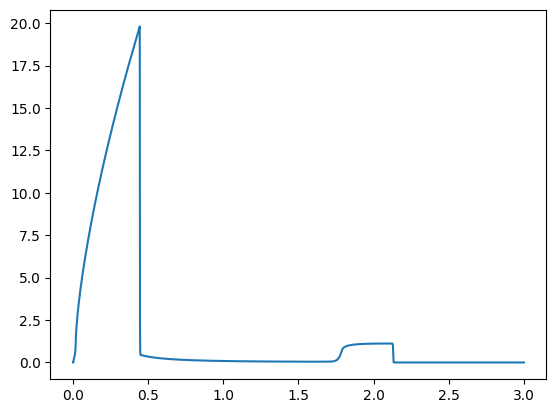

In [7]:
# calculate the mach number
p = final_state_high_res[registered_variables.pressure_index]
rho = final_state_high_res[registered_variables.density_index]
speed_of_sound = jnp.sqrt(gamma * p / rho)
mach_number = final_state_high_res[registered_variables.velocity_index] / speed_of_sound

# plot the mach number
fig, ax = plt.subplots()
r_high_res = helper_data_high_res.geometric_centers * code_units.code_length
ax.plot(r_high_res.to(u.parsec), mach_number)
# --> mach number high at reverse shock, up to 20